[*********************100%%**********************]  1 of 1 completed


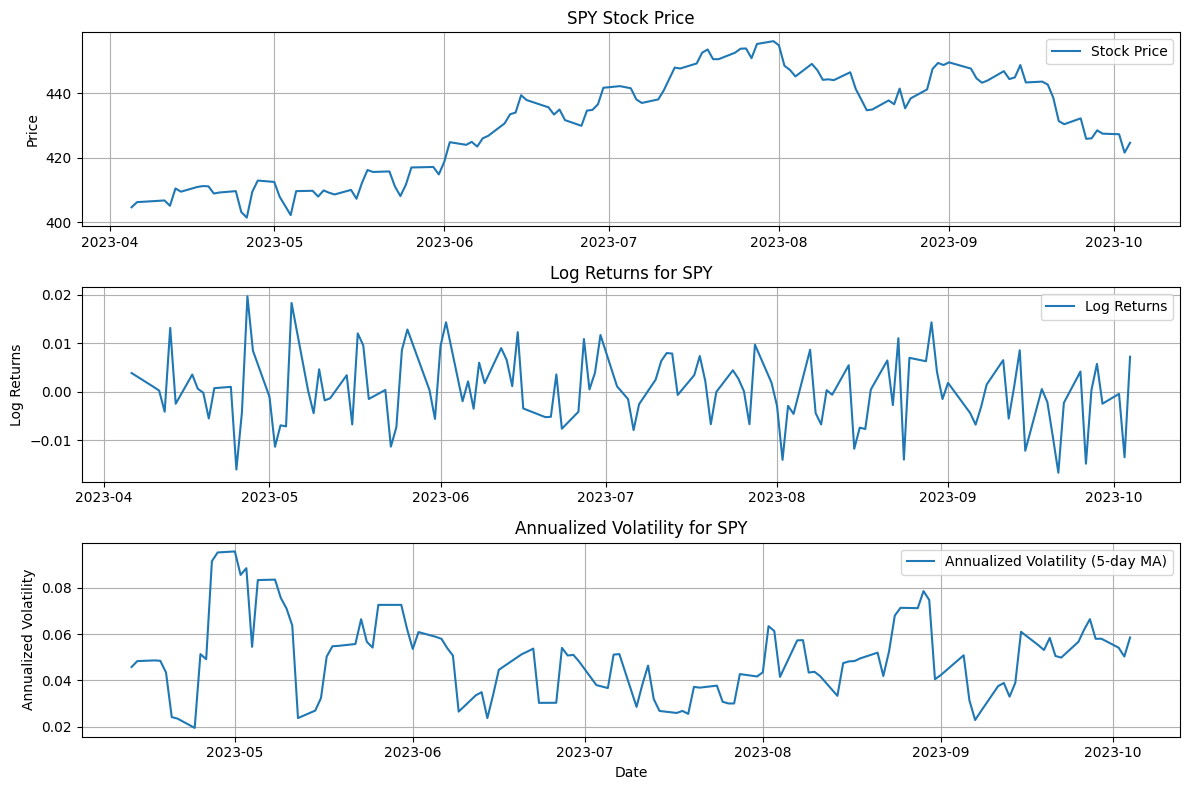

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Define the ticker symbol and the start/end dates for the data
ticker_symbol = 'SPY'
end_date = datetime.date.today()
start_date = pd.to_datetime(end_date) - pd.DateOffset(months=6)

# Fetch historical data using yfinance
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Calculate log returns
data['Log_Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# Calculate volatility using a rolling window of 5 days
rolling_window = 5
data['Volatility'] = data['Log_Returns'].rolling(window=rolling_window).std()

# Annualize volatility
total_trading_days = len(data)
annualization_factor = np.sqrt(252 / rolling_window)  # Assuming 252 trading days in a year
data['Annualized_Volatility'] = data['Volatility'] * annualization_factor

# Plot stock price, log returns, and annualized volatility
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(data.index, data['Adj Close'], label='Stock Price')
plt.title('SPY Stock Price')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data.index, data['Log_Returns'], label='Log Returns')
plt.title('Log Returns for SPY')
plt.ylabel('Log Returns')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(data.index, data['Annualized_Volatility'], label='Annualized Volatility (5-day MA)')
plt.title('Annualized Volatility for SPY')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

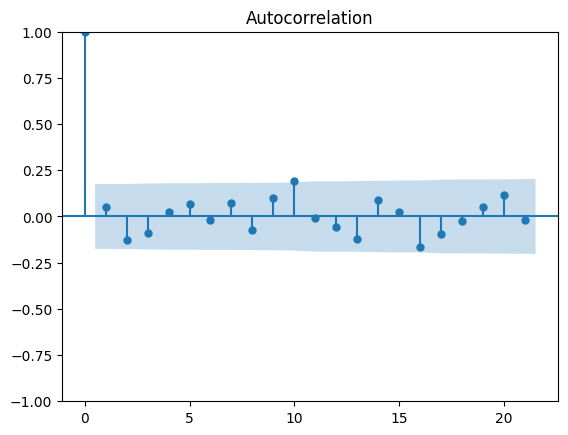

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Log_Returns'].dropna().values);

In [18]:
from arch import arch_model

parameter_test_values = [0, 1, 2, 3]
best_score = 1e6

for p_test in parameter_test_values:
    for q_test in parameter_test_values:
        if (p_test + q_test) == 0:
            break
        model = arch_model(100*data['Log_Returns'].dropna(), p=p_test, q=q_test)
        model_fit = model.fit(disp='off')
        score = model_fit.aic
        if best_score == None or score < best_score:
            best_score = score
            best_fit = model_fit
best_fit.summary()

# model = arch_model(100*data['Log_Returns'].dropna(), p=1, q=1)
# model_fit = model.fit()
# aic_score = model_fit.aic
# model_fit.summary()

c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:1894: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:1895: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:1896: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -136.632
Distribution:                  Normal   AIC:                           279.264
Method:            Maximum Likelihood   BIC:                           287.749
                                        No. Observations:                  125
Date:                Thu, Oct 05 2023   Df Residuals:                      124
Time:                        22:58:54   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0386  6.617e-02      0.583      0.560 [-9.111e-02,  0.168]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5211      0.113      4.597  4.282e-06 [  0.299,  0.743]
alpha[1]       0.0000      0.289      0.000      1.000 [ -0.566,  0.566]
========================================================================

Covariance estimator: robust
"""

c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\volatility.py:1196: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:451: RuntimeWarning: divide by zero encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\arc

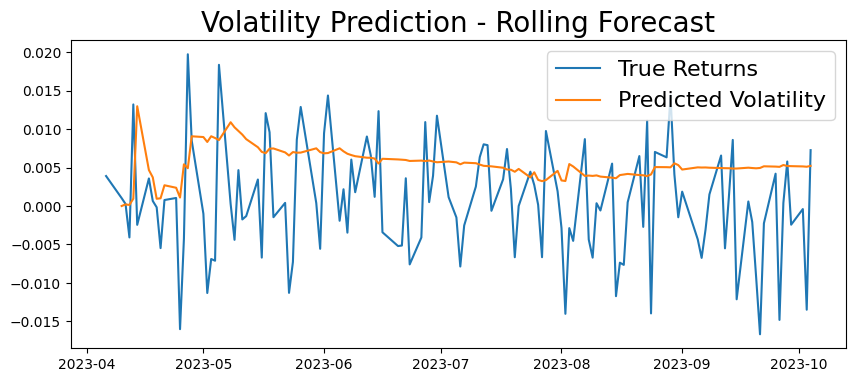

In [19]:
rolling_predictions = []
test_size = len(data['Log_Returns'].dropna().values)-1

for i in range(test_size):
    train = 100*data['Log_Returns'].dropna()[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(pred.variance.values[-1,:][0])

rolling_predictions = pd.Series(np.divide(rolling_predictions,100), index=data['Log_Returns'].index[-test_size:])

plt.figure(figsize=(10,4))
true, = plt.plot(data['Log_Returns'].dropna()[-365:])
preds, = plt.plot(rolling_predictions)

plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\Mustafa\AppData\Local\Temp\ipykernel_18776\4160718717.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"The next volatility predicted is: {next_week_vol[0]}")


The next volatility predicted is: 0.005211248135412849


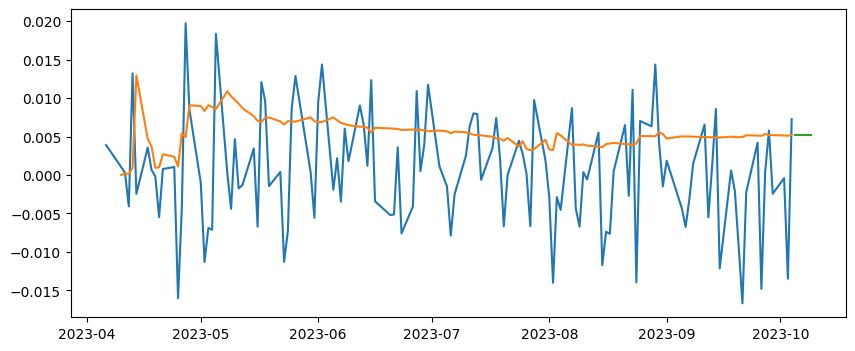

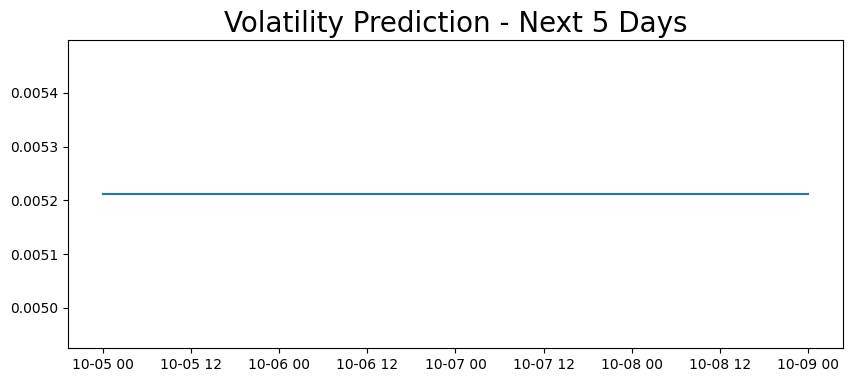

In [20]:
forecast_time = 5
next_week_vol = best_fit.forecast(horizon=forecast_time)
future_dates = [data['Log_Returns'].index[-1] + datetime.timedelta(days=i) for i in range(1,forecast_time+1)]
next_week_vol = pd.Series(np.divide(next_week_vol.variance.values[-1,:],100), index=future_dates)

plt.figure(figsize=(10,4))
true, = plt.plot(data['Log_Returns'].dropna()[-365:])
preds, = plt.plot(rolling_predictions)
next_week_plot, = plt.plot(next_week_vol)
plt.figure(figsize=(10,4))
plt.plot(next_week_vol)#*np.sqrt(252))
plt.title('Volatility Prediction - Next 5 Days', fontsize=20)
print(f"The next volatility predicted is: {next_week_vol[0]}")